<a target="_blank" href="https://colab.research.google.com/github/yuvalgos/policy_gradient_tutorial/blob/main/PolicyGadient.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%matplotlib inline

In [2]:
!pip install "git+https://github.com/yuvalgos/policy_gradient_tutorial"

  Cloning https://github.com/yuvalgos/policy_gradient_tutorial to c:\users\yuval\appdata\local\temp\pip-req-build-7s6kxe7l
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'


  Running command git clone -q https://github.com/yuvalgos/policy_gradient_tutorial 'C:\Users\yuval\AppData\Local\Temp\pip-req-build-7s6kxe7l'
You should consider upgrading via the 'C:\Study\col_ai\pg_tutorial\venv\Scripts\python.exe -m pip install --upgrade pip' command.


# Policy Gradient

## The Environment For This Tutorial
In this tutorial we are going to work on the gymnasium Pendulum environment: https://gymnasium.farama.org/environments/classic_control/pendulum/

<img src="assets/pendulum.gif" style="height:200px">

In this environment, the agent's goal is to level the pendulum so that it will face up and keep it there.

The agent observes a three-dimensional vector of the pendulum free end position (x,y) and its angular velocity:

<img src="assets/pendulum_state.png" style="height:220px">

Its action is one element indicating what torque (force) to apply to the pendulum.

<img src="assets/pendulum_action.png" style="height:100px">

The reward function is negative, penalizing for how far the pendulum is from being upright, its angular velocity, and for the torque the agent applies.
The reward in each time-step can be between -16.27 to 0.

<img src="assets/pendulum_reward.png" style="height:35px">

At each episode, the pendulum starts at a random state, and the agent acts for a fixed number of steps $T=200$.


#### <img src="https://em-content.zobj.net/thumbs/240/apple/354/party-popper_1f389.png" style="height:30px"> Code Time
Let's create and run the envrionment once with random actions.
Here, we sample random action from the state space at each timestep.

In [3]:
import gymnasium as gym
%matplotlib inline

# for simplicity and time saving, we will make our environment easier by reducing gravity
gravity = 1.0
env = gym.make("Pendulum-v1", render_mode="rgb_array", g=gravity)

Ran for 200 time steps and accumulated -1054.4212039496215 reward



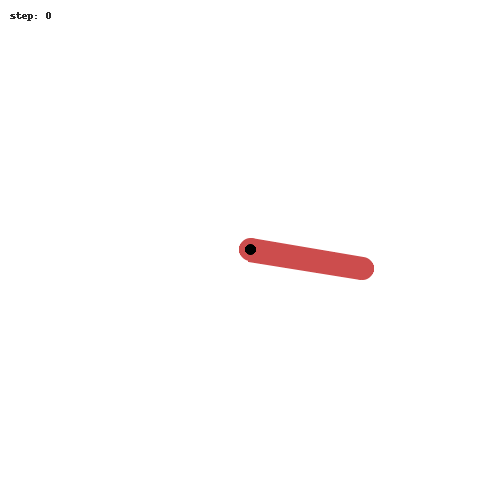

In [4]:
from pg_tutorial.utils import plot_video

# run one episode with random actions:
terminated, truncated = False, False
total_reward = 0.0
time_steps = 0
images = []
observation, info = env.reset()
while not terminated and not truncated:
    images.append(env.render())
    action = env.observation_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    time_steps += 1

print(f"Ran for {time_steps} time steps and accumulated {total_reward} reward")
plot_video(images)

## Policy Based Methods
We have seen that Q learning is not scalable to a high dimensional state space; we can use function approximation methods (such as neural networks) to estimate our Q function. However, we still have to output the value of each action. What if we have continuous or too many possible actions? We will meet the curse of dimensionality.

In this tutorial we are going to present a different approach: **Policy Based Methods** and specifically **Policy Gradient Methods**.
Instead of learning the Q function, we will learn a **parameterized policy** $\pi_{\theta}(s) = \pi(s;\theta)$ where $\theta$ is a set of learnable parameters and $\pi$ is a distribution function over all possible actions.

<img src="assets/policy_vs_value.png" style="height:350px">

#### Advantages of Policy based RL
* Better convergence properties
* Can work with large and continuous action spaces
* Works for stochastic policies

#### Disadvantages
* Might converge to a local minima
* High variance (unless combined with Value-Based)

#### Why stochastic policies?

consider the following grid environment, which represents a POMDP.
The agent may only observe the wall configuration around him (whether there is a wall or other cell in each of the 4 directions).
The episode starts randomly in one of the grey cells. 

<img src="assets/grid_for_stochastic.png" style="height:150px">

Any deterministic policy, can start at some state and be stuck without ability to reach the goal.

<img src="assets/grid_for_stochastic_bad.png" style="height:150px">

But a policy that chooses random action at those states will always reach the goal eventually.

<img src="assets/grid_for_stochastic_good.png" style="height:150px">

**Another example:** think what the optimal policy is for playing rock-paper-scissors?

## Parameterized Policy
A parametrized policy can be any function with parameters that has an input of a state, outputs a distribution function over actions, and has learnable parameters.

Recall our state space, we will denote each state as a vector of three elements:

<img src="assets/state_vector.png" style="height:100px">

We will use a vanilla policy first, which is a very simple policy that we can easily implement:

<img src="assets/vanilla_policy.png" style="height:50px">

where $\theta_1, \theta_2, \theta_3$ are our parameters, and $s_1, s_2, s_3$ are the three state elements we mentioned earlier:

## Improving the policy
Now that we have a parameterized policy, we need to find the best parameters $\theta$ that will lead this policy to accumulate as high a reward as possible. How do we do that? Possibly with gradient descent.

We would like to maximize the return. We will denote the return here by $J$. Note that it depends on the policy, and thus it depends on its parameters $\theta$.

<img src="assets/return.png" style="height:100px">

If we could compute the gradient of $J$ with respect to the parameters of the policy $\theta$, we would be able to take a small step in the parameter space in the direction of the gradient, thus increasing the return and improving the policy.

## Policy Gradient Theorem
It turns out (and it's not that obvious) that the gradient of the return with respect to the policy parameter can be computed.
The proof is not trivial, but the result is

<img src="assets/pg_theorem.png" style="height:80px">

In words: 
* We compute expectation over the distribution of state action pairs met in the MDP by running the policy $\pi_{\theta}$ in it (formally: the stationary distribution of the markov chain induced by the policy)
* For each state action pair, we compute the gradient of the log of the probability (according to the policy) of taking  that action at that state. Note that this gradient is a vector in the dimension of the parameters: we compute the gradient with respect to each parameter. This gradient can be computed since we have our $\pi$.
* We multiply this probability by the value of the state action pair; this is the part of the state action pair in the gradient.

Question you should ask:
* How do we compute the expectation if there is an infinite number of state-action pairs?
* How do we know the Q-value of the state-action pair?

We will see in a minute how **REINFORCE** algorithm tackles these questions.

#### About the proof
We are not going to show the full proof, but you must be wondering where the log comes from. It comes from the following identity used in the proof:

<img src="./assets/pg_identity.png" style="height:100px">

## Implementation and Gradient in Our Policy
Let's create an implementation of our policy

<img src="assets/vanilla_policy.png" style="height:50px">

But note that for the policy gradient, we will need to compute the gradient of the log of the policy $\nabla_\theta log(\pi_\theta(a|s))$. Actually, since our policy is deterministic, it chooses an action for each state with probability 1, and therefore the gradient zeroes for any action except for the chosen one. Inside the expectation, we can write this term as: $\nabla_\theta log(\pi_\theta(s))$.

Now we can easily compute the gradient using the chain rule:

<img src="./assets/log_grad.png" style="height:300px">

#### <img src="https://em-content.zobj.net/thumbs/240/apple/354/party-popper_1f389.png" style="height:30px"> Code Time
Now we can implement our vanilla policy with everything we need to run our algorithm.

***Note:*** *For simplicity, this policy implementation is for pendulumn envrionment with state space of size 3 and action space of size 1. but It's easy to create a generic policy implementation*

In [5]:
import numpy as np

class PendulumVanillaPolicy:
    def __init__(self):
        self.theta_1 = np.random.uniform(-1, 1)
        self.theta_2 = np.random.uniform(-1, 1)
        self.theta_3 = np.random.uniform(-1, 1)
        
    def get_action(self, state):
        # action is deterministic for this policy:
        return np.array([self.theta_1 * state[0] + self.theta_2 * state[1] + self.theta_3*state[2]])

    def gradient(self, state):
        return np.array([state[0], state[1], state[2]])

    def grad_log_likelihood(self, state):
        # compute grad (log(pi(s)) according to the chain rule:
        return (1 / self.get_action(state)) * self.gradient(state)
    
    def sample_action(self, state):
        # used by our algorithm, returns action and the log likelihood gradient of this action
        return self.get_action(state), self.grad_log_likelihood(state)

    def get_parameters_vector(self):
        return np.array([self.theta_1, self.theta_2, self.theta_3])

    def set_parameters_vector(self, parameters_vector):
        self.theta_1, self.theta_2, self.theta_3 = parameters_vector

We have provided you with two utility functions:
 One to evaluate the policy for a given number of episodes and return the mean accumulated reward. It's important to average over multiple episodes because both the start state and the policy are random.
 The second one will visually record the policy in the environment and will play it.

mean reward over 10 episodes: -1775.945099789543



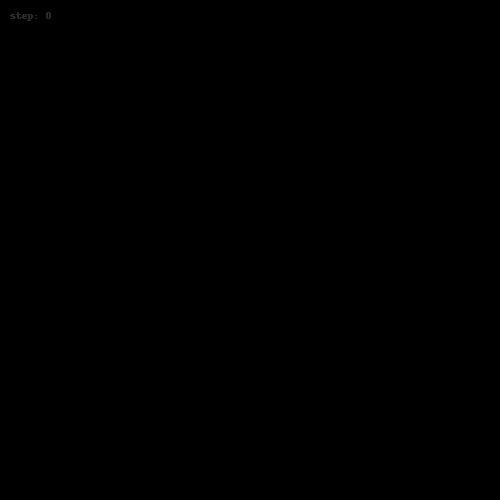

In [6]:
from pg_tutorial.utils import evaluate_agent, visualize_policy

policy = PendulumVanillaPolicy()

mean_reward = evaluate_agent(policy, env, n_episodes=10)
print("mean reward over 10 episodes:", mean_reward)

visualize_policy(policy, env) 

## REINFORCE
![](assets/reinforce_paper.png)



Policy gradient is just a Theorem or a concept. REINFORCE, is an algorithm that uses the policy gradient theorem, along with monte carlo estimation in order to train a parametrized policy.

Recall that we don't know the distribution of $Q^{\pi_{\theta}}(s,a)$, and thus we can't compute this expectation.
In REINFORCE we approximate the expectation over the Q value of pi, with samples of returns from the environment.



<img src="assets/REINFORCE.png" style="height:500px">

* model based/free?
* on/off policy?

## REINFORCE Implementation
In each outer iteration of reinforce, we need to collect an episode with our current policy. Let's implement a function to do that. 
We will need to compute returns for each step of this episode, so we will save the reward in each step. For the policy gradient, we don't need the states and actions explicitly, only $\nabla_\theta log(\pi_\theta(a|s))$, which we will call "grad log likelihood" and will collect it for each step.

#### <img src="https://em-content.zobj.net/thumbs/240/apple/354/party-popper_1f389.png" style="height:30px"> Code Time

In [7]:
import numpy as np
from pg_tutorial.utils import ActivePlotter

def collect_episode(env, policy):
    """
    collect one episode with the required data for reinforce, for each step return:
     - the reward
     - the gradient of the log likelihood for the action taken at the state
    each in a list in the length of the episode (we don't need more than that for reinforce
    """
    episode_rewards, actions_log_likelihood_grads = [], []  # to be returned
    terminated, truncated = False, False
    state, _ = env.reset()
    while (not terminated) and (not truncated):
        action, log_likelihood_grad = policy.sample_action(state)
        state, reward, terminated, truncated, info = env.step(action)
        actions_log_likelihood_grads.append(log_likelihood_grad)
        episode_rewards.append(reward)
    
    return episode_rewards, actions_log_likelihood_grads

For each step, we have the reward, but for the policy gradient we need the return, which is the cumulative discounted reward that the agent achieved from the current step until the end of the episode. Let's implement a function to compute that, from end to start. We will also normalize our returns for each episode for numerical stability.

In [8]:
def compute_returns(episode_rewards, gamma):
    """ given reward collected for each step and a discount factor, compute the return for this step, should be efficient. """
    episode_returns = []
    current_return = 0
    for reward in episode_rewards[::-1]:
        current_return = reward + gamma * current_return
        episode_returns.insert(0, current_return)
    
    return episode_returns


def normalize_returns(episode_returns):
    """ normalize the returns for an episode for numerical stability """
    episode_returns = np.array(episode_returns)
    episode_returns = (episode_returns - episode_returns.mean()) / (episode_returns.std() + 1e-9)
    return episode_returns

Now for the algorithm implementation: it is almost identical to the definition above. In each iteration we will collect an episode, compute returns, update the parameters for each step, and then set the policy with the new parameters.

In [9]:
def reinforce(env, policy, learning_rate=0.0002, gamma=0.97, n_episodes=750, plotter=None):
    mean_eval_rewards = []
    for episode in range(n_episodes):
        # collect one episode:
        episode_rewards, actions_log_likelihood_grads = collect_episode(env, policy)
        
        # compute returns:
        episode_returns = compute_returns(episode_rewards, gamma)
        episode_returns = normalize_returns(episode_returns)
        
        # retrive parameters, and change them in the direction of the gradient:
        policy_parameters = policy.get_parameters_vector()
        for i in range(min(len(episode_returns), 150)):  # ignore the last 50 steps. Think why?
            ret = episode_returns[i]
            log_likelihood_grad = actions_log_likelihood_grads[i]
            
            policy_parameters = policy_parameters + learning_rate * ret * log_likelihood_grad
        # update the policy with the new parameters:
        policy.set_parameters_vector(policy_parameters)
        
        # evaluate:
        if episode % 5 == 0:
            mean_reward = evaluate_agent(policy, env, n_episodes=5)
            mean_eval_rewards.append(mean_reward)
            if plotter is None:
                print(f"Episode {episode}: Evaluation mean accumulated reward = {mean_reward}")
            else:
                plotter.update_plot(episode, mean_reward)

    return mean_eval_rewards

## Solving Pendulum Environment With Reinforce


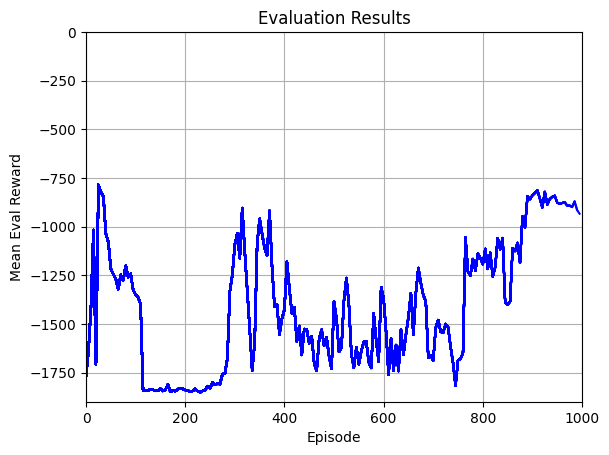

In [10]:
# let's make sure we all get the same result
import random
random.seed(42)
np.random.seed(42)

plotter = ActivePlotter(max_iteration=1000)
env = gym.make("Pendulum-v1", render_mode="rgb_array", g=gravity)
policy = PendulumVanillaPolicy()

vanilla_mean_eval_rewards = reinforce(env, policy, gamma=0.97, learning_rate=0.0005, n_episodes=1000, plotter=plotter)

agent evaluation mean reward: -903.605534941558



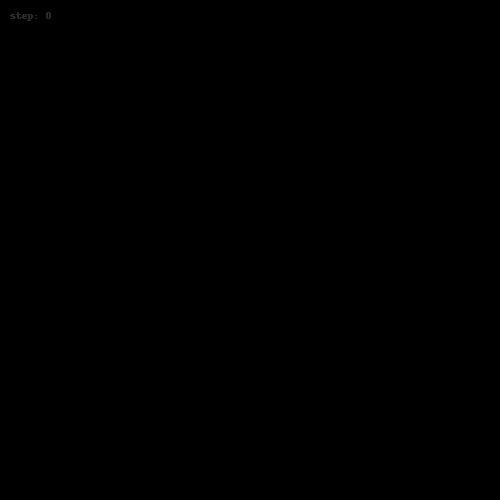

In [11]:
agent_evaluation = evaluate_agent(policy, env, n_episodes=20)
print(f"agent evaluation mean reward:", agent_evaluation)

visualize_policy(policy, env, n_episodes=2)

How did it perform? Think - why?

Let's print the parameters we converged to.

In [12]:
converged_parameters = policy.get_parameters_vector()
print(policy.get_parameters_vector())

[17.04619781  7.39700081 -0.84097315]


## Parameter Space Visualization
Since our vanilla policy is quite simple and only has 3 parameters, we can look at some interesting stuff.
We would like to plot the agent's value in the parameter space around the point we have converged to. Reminder: this is the space in which we computed the gradient and improved the agent.

Since we have three parameters + the evaluation, and the best we can do is 3D plot, we will freeze $\theta_3$ to a fixed value and look at changes for $\theta_2, \theta_1$.
The following cell uses a function we implemented:
* it takes the policy parameters we have converged to
* it evaluates the agent for the same $\theta_3$ but with different $\theta_2, \theta_1$ values around the convergence parameters
* each evaluation is counting the accumulated reward for 3 episodes and averages it (because start state is random)
* the z-axis is the mean accumulated reward for 3 episodes
* the red point in the middle represents the original parameters that REINFORCE converged to

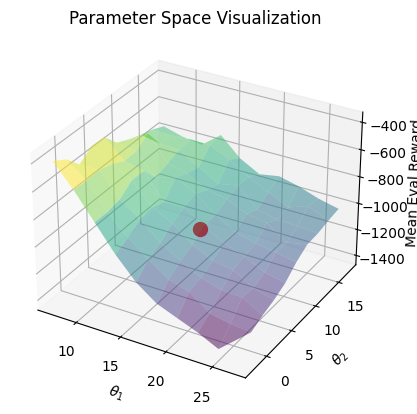

In [13]:
from pg_tutorial.parameter_space_visualization import visualize_parameter_space
visualize_parameter_space(policy, env, thetas_range=10, n_thetas=10)

<img src="https://em-content.zobj.net/thumbs/240/whatsapp/352/astonished-face_1f632.png" style="height:60px">
Seems like there is a better combination of parameters than the one we have converged to! Our parameters didn't find the maximum!

How is that possible?

* Gradient descent/ascent based algorithms don't guarantee convergence to a global maximum/minimum, especially when there are local extremum points along the way. It seems that we have converged to a local maximum. Look how noisy the parameter space and how many local maximums are there.
* We didn't have the exact gradient direction in each iteration. Recall that we use Monte-Carlo approximation for the value part in the policy gradient, and that we approximate the expectation with finite amount of samples, and thus we don't have the real gradient but something that is close enough to it.


## Drawbacks of REINFORCE
Note the oscillation in the convergence of REINFORCE - this happens due to the high variance in the monte-carlo estimation of the expected return.
This variance makes the algorithm unstable; Even in the next section, where we will get better results, if you will try to run it with multiple seeds you will see that sometimes it doesn't converge, and sometimes it starts to converge and then collapses back to be as good as a random policy.

One approach to solve this and get a better algorithm is replacing the monte carlo approximation of the return, with a value function approximate like in Q-learning.
Such methods are called **Actor-Critic** methods. 
(remember this figure?)

<img src="assets/policy_vs_value.png" style="height:350px">

## REINFORCE With Deep Neural Network Policy

It seems that REINFORCE didn't manage to converge to a good enough policy with the policy function we used. Maybe it wasn't expressive or complex enough.
One representation of a parametric function is a neural network. If you don't know neural networks, don't worry about it. All you have to know is that it is a function approximator with learnable parameters we will call $\theta$. Neural networks can learn complex functions.

#### <img src="https://em-content.zobj.net/thumbs/240/apple/354/party-popper_1f389.png" style="height:30px"> Code Time
We have provided you with an implementation of a neural network policy. As mentioned earlier, you don't need to know how it's implemented, all you need to know is what it does and how to access its parameters.
We will initialize a policy with the size of our state space as input and our action space as output.
This is a stochastic policy! It doesn't output an action, but a distribution function over actions. In this policy, the action distribution is modeled as a gaussian distribution, and the policy outputs the mean and variance of the gaussian. 

action mean: [-0.00555576]; action variance: [0.5884541]


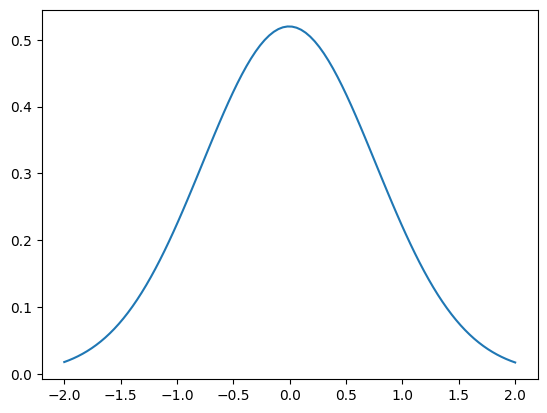

In [14]:
from pg_tutorial.parameterized_policy import ParameterizedGaussianPolicy
from pg_tutorial.utils import plot_gaussian

policy = ParameterizedGaussianPolicy(state_dim=3, action_dim=1, action_range=2)
dummy_state = [1, 1, 1]
action_mean, action_var = policy.get_action_distribution(dummy_state)
print(f"action mean: {action_mean}; action variance: {action_var}")

plot_gaussian(action_mean, action_var)

Instead of using the policy to get the action distribution, you can directly sample an action from this distribution using the *sample_action* method. Note that this method has two outputs and already outputs the log likelihood grad for us.

In [15]:
action, grad_log_likelihood = policy.sample_action(dummy_state)
print(action)

[0.93240917]


#### Neural Network Parameters
In a neural network, the parameters are multiple matrices and vectors, but in our policy, this is abstracted, and you can get all the parameters as one long vector. you can modify this vector and then change the policy parameters to the new vector, which makes it compatible with our implementation of REINFORCE.

Remember how many parameters were in the vanilla policy?

In [16]:
theta_params = policy.get_parameters_vector()
print(f"there are {len(theta_params)} in this policy")
print(theta_params)

there are 8898 in this policy
[ 0.23209989 -0.47722083  0.02195042 ...  0.01359636 -0.11238743
 -0.0779414 ]


In [17]:
theta_params = theta_params + 0.001
policy.set_parameters_vector(theta_params)

#### The grad log likelihood
As mentioned, we can easily compute $\nabla_{\theta} log(\pi_{\theta} (s|a)$ for any state action if we have the policy function, which we do.
Actually, it is already computed for you when you sample an action given a state. Remember that policy.sample_action(state) has two outputs? Well, the second one is the gradient vector $\nabla_{\theta} log(\pi_{\theta} (s|a)$ for the input state and the sampled action!

In [18]:
action, grad_log_likelihood = policy.sample_action(dummy_state)

# The grad log likelihood is a gradient vector, therefore it has the same size as theta!
print(f"gradient log likelihood size: {len(grad_log_likelihood)}")
print(grad_log_likelihood)

gradient log likelihood size: 8898
[-0.02944833 -0.02944833 -0.02944833 ...  0.          0.
 -0.59378767]


#### TODO 1: 
complete the following cell to run REINFORCE on the pendulum environment with a ParameterizedGaussianPolicy. This should be quite similar to running it with the vanilla policy.
Run it for 500 episodes and use: $ \gamma = 0.97;   learning\_rate = 0.0005;$ It should take few minutes (less than 5) and converge to a policy that learns to balance the pendulum (less than -100 average accumulated reward)

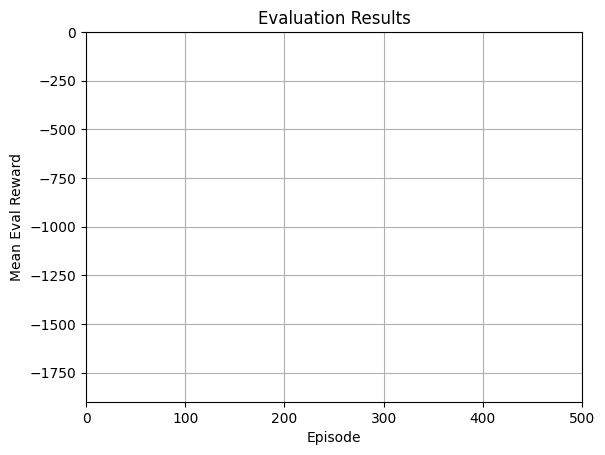

In [28]:
# let's make sure we are all getting the same result:
np.random.seed(2023)
import torch
torch.manual_seed(2023)
plotter = ActivePlotter(max_iteration=500)

### TODO: run reinforce with NN policy for 500 episodes ###
# create env and policy here
# NN_mean_eval_rewards = reinforce(uncomment and complete this

#### TODO 2:
Evaluate the NN policy and play the video for it. Use the provided utility functions.

In [27]:
### TODO: evaluate the agent for 20 episodes and print the mean accumulated reward ###
### TODO: create a video of 4 episodes ###


## comparison between Vanilla and NN policies
Run the following cells to see the results of both policies compared:

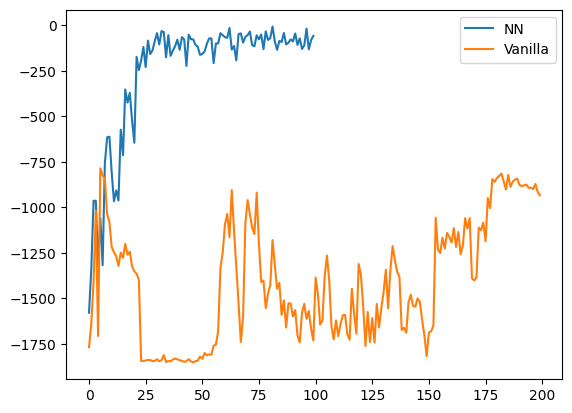

In [26]:
import matplotlib.pyplot as plt
plt.plot(NN_mean_eval_rewards, label="NN")
plt.plot(vanilla_mean_eval_rewards, label="Vanilla")
plt.legend()
plt.show()

#### Optional TODO 3:
Create a new pendulum environment with gravity=10. Run reinforce with neural network policy for this environment. Did it manage to learn to balance the pendulum? If not why. Think what should be the long term policy to balance the pendulum in that case.

In [21]:
# TODO 3:
